# Melanoma Classification with Convolutional Neural Networks

We will used the Melanoma ISIC Dataset
(https://www.isic-archive.com/#!/topWithHeader/wideContentTop/main)

Download the images and metadata using the API for that purpose.

In [1]:
!git clone https://github.com/GalAvineri/ISIC-Archive-Downloader

Cloning into 'ISIC-Archive-Downloader'...
remote: Enumerating objects: 292, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 292 (delta 0), reused 0 (delta 0), pack-reused 288
Receiving objects: 100% (292/292), 75.17 KiB | 3.13 MiB/s, done.
Resolving deltas: 100% (175/175), done.


In [2]:
## One Option is Before download the images, edit the download_archive.py in line 207, setting directly ----> res='y'
## Another option is to click just besides [y/n] and type 'y' then enter

## It will create a 'Data' Folder with sub-folders Description and Images
#!python ISIC-Archive-Downloader/download_archive.py --num-images=1000 ## works but download an unbalance dataset
!python ISIC-Archive-Downloader/download_archive.py --num-images 150 --filter malignant
!python ISIC-Archive-Downloader/download_archive.py --num-images 150 --filter benign --offset 150


You have decided to do the following:
Download maximum of 150 elements
start with offset 0
filter only malignant images
Descriptions will be downloaded to /content/Data/Descriptions
Images will be downloaded to /content/Data/Images
Use 16 processes to download the archive
Do you confirm your choices? [Y/n] y
Malignants Found: 100% 150/150 [01:01<00:00,  2.44it/s]
Found 150 malignant images
Finished downloading
You have decided to do the following:
Download maximum of 150 elements
start with offset 150
filter only benign images
Descriptions will be downloaded to /content/Data/Descriptions
Images will be downloaded to /content/Data/Images
Use 16 processes to download the archive
Do you confirm your choices? [Y/n] y
Benigns Found: 100% 150/150 [00:21<00:00,  6.93it/s]
Found 150 benign images
Finished downloading


In [3]:
# Now let's import some useful packages
import json
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings("ignore")


In [4]:
# Lets organize the data
desc_path = 'Data/Descriptions/'
images_path = 'Data/Images/'

df_files = pd.DataFrame(os.listdir(desc_path), columns=['Name'])
print(df_files.head())

           Name
0  ISIC_0000297
1  ISIC_0000029
2  ISIC_0000149
3  ISIC_0000284
4  ISIC_0000217


In [5]:
label = []
label_value = []
for ii in range(len(df_files)):
  filename = os.path.join(desc_path,df_files['Name'][ii])

  with open(filename) as read_file:

    data=json.load(read_file)

    
  #retrieve the label from the metadata
  label.append(data['meta']['clinical']['benign_malignant'])
  label_value.append( 0 if data['meta']['clinical']['benign_malignant']=='benign' else 1)

print(len(label))

300


In [6]:
# Append the label to the DataFrame
df_files['label']= label
df_files['label_value']= label_value


In [7]:
df_files.head()

,Name,label,label_value
0,ISIC_0000297,malignant,1
1,ISIC_0000029,malignant,1
2,ISIC_0000149,malignant,1
3,ISIC_0000284,malignant,1
4,ISIC_0000217,benign,0


# Import Pytorch packages

In [8]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report

import time
from torchvision import transforms, utils
from torchsummary import summary
import copy
import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(42)
np.random.seed(42)

In [9]:
## Lets define the dataset for training and testing. Check the stratify option. Can you think about why it is important this feature?

df_files_train, df_files_test = train_test_split(df_files, test_size=0.2, random_state=42, stratify=df_files.label_value  )
print(len(df_files_train))
print(len(df_files_test))

df_files_train=df_files_train.reset_index()
df_files_test=df_files_test.reset_index()


240
60


In [13]:
print(df_files_test['label_value'].value_counts())
print(df_files_train['label_value'].value_counts())

1    30
0    30
Name: label_value, dtype: int64
1    120
0    120
Name: label_value, dtype: int64


In [20]:
len(df_files_test)

60

In [38]:
# Create Dataset
# ToDO: Complete what is missing to make it work 
class Dataset(torch.utils.data.Dataset):
  def __init__(self, img_path, desc_path, df_files, transforms):
    super().__init__()
    self.img_path = img_path
    self.desc_path = desc_path
    self.df_files = df_files
    self.transforms = transforms
    
    
  def __len__(self,):
      return len(self.df_files)
  
  def __getitem__(self, idx):
    image  = Image.open(os.path.join(self.img_path, self.df_files['Name'][idx]+'.jpeg' ))
    image_name = self.df_files['Name'][idx]
    # im = Image.open("D:/images/sample-image.png")

    target = np.array(self.df_files['label_value'][idx])

    if self.transforms:
      image = self.transforms(image)

    return {
        'image_name':image_name,
        'image': image,
        'target': torch.from_numpy( target ).long()
    }

train_composed = transforms.Compose([transforms.ToTensor(),
                               transforms.Resize(256),
                               transforms.RandomCrop(224),
                               transforms.RandomVerticalFlip(),
                               transforms.RandomHorizontalFlip(),
                               transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])
            ])

val_composed = transforms.Compose([transforms.ToTensor(),
                               transforms.Resize(256),
                               transforms.RandomCrop(224),
                               #transforms.RandomVerticalFlip(),
                               #transforms.RandomHorizontalFlip(),
                               transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])
            ])


## Create the object
dataset_train= Dataset(img_path=images_path,
                       desc_path=desc_path,
                       df_files=df_files_train,
                       transforms=train_composed )

## Create the object
dataset_test = Dataset(img_path=images_path,
                       desc_path=desc_path,
                       df_files=df_files_test,
                       transforms=val_composed )  


# ToDO
# complete the proper inputs to the DataLoaders
train_loader = torch.utils.data.DataLoader(dataset_train)
test_loader = torch.utils.data.DataLoader(dataset_test)


In [41]:
for d in train_loader:
  print(d)
  break

{'image_name': ['ISIC_0000394'], 'image': tensor([[[[ 0.0667,  0.0745,  0.0931,  ...,  0.1898,  0.2133,  0.2132],
          [ 0.0510,  0.0745,  0.1059,  ...,  0.1922,  0.2000,  0.1922],
          [ 0.0689,  0.0902,  0.1059,  ...,  0.2000,  0.1843,  0.1843],
          ...,
          [ 0.0224,  0.0118,  0.0275,  ..., -0.1529, -0.1475, -0.1529],
          [-0.0118,  0.0118,  0.0196,  ..., -0.1686, -0.1686, -0.1451],
          [ 0.0067,  0.0167,  0.0118,  ..., -0.1584, -0.1638, -0.1711]],

         [[-0.1087, -0.1002, -0.1010,  ...,  0.1898,  0.2133,  0.2132],
          [-0.1216, -0.0980, -0.0980,  ...,  0.2000,  0.2078,  0.2000],
          [-0.0902, -0.0510, -0.0667,  ...,  0.2078,  0.1843,  0.1765],
          ...,
          [-0.0090,  0.0039,  0.0196,  ..., -0.3804, -0.3828, -0.3961],
          [-0.0039,  0.0196,  0.0196,  ..., -0.3804, -0.3647, -0.3569],
          [ 0.0067,  0.0167,  0.0118,  ..., -0.3702, -0.3828, -0.3804]],

         [[-0.2650, -0.2442, -0.2863,  ...,  0.1741,  0.2289

IndexError: ignored

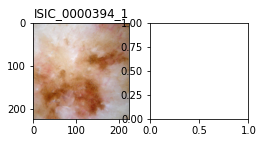

In [43]:
# from https://juansensio.com/blog/065_transformer_decoder
for data in train_loader:
  # print(data)
  r, c = 3,3
  fig = plt.figure(figsize=(c*2,r*2) )
  for r_ in range(r):
    for c_ in range(c):
      ix = r_*c + c_ 
      ax = plt.subplot(r,c, ix + 1)
      img = data['image'][ix].cpu().numpy().transpose()
      img = (img-img.min())/(img.max()-img.min())
      label = data['target'][ix].cpu().numpy()

      ax.imshow(img)
      ax.set_title( data['image_name'][ix]+'_'+str(label))
  plt.tight_layout()
  plt.show()
  
  break
  

In [ ]:
# from https://juansensio.com/blog/065_transformer_decoder
for data in test_loader:
  # print(data)
  r, c = 3,3
  fig = plt.figure(figsize=(c*2,r*2) )
  for r_ in range(r):
    for c_ in range(c):
      ix = r_*c + c_ 
      ax = plt.subplot(r,c, ix+1)
      img = data['image'][ix].cpu().numpy().transpose()
      img = (img-img.min())/(img.max()-img.min())

      label = data['target'][ix].cpu().numpy()

      ax.imshow(img)
      ax.set_title( data['image_name'][ix]+'_'+str(label))
  plt.tight_layout()
  plt.show()
  
  break

In [ ]:
# Define a MLP MODEL for benchmark later the CNN performance
# TODO: Complete the Sequential to define a 3 layers MLP, with an input layer to accept an image of [224,224,3], with ReLU activation 
model_MLP = nn.Sequential(
    ...
    nn.LogSoftmax(dim=1)
)


In [ ]:
print(model_MLP)

In [ ]:
# TODO 
## Check the num of parameters and size of the network
summary(model_MLP, input_size=(1, 3*224*224), device='cpu')


In [ ]:
def test_loop_MLP(test_loader, criterion, model, DEVICE):
  model.to(DEVICE)
  pred = [] 
  correct = 0
  loss=[] 
  for test_data in test_loader:
    with torch.no_grad():
      
      # ToDo:  Complete the forward properly.
      bz, _, _, _ = ... 
      y_pred = model( ... )
      
      
      loss.append( criterion(y_pred, test_data['target'].to(DEVICE)).item() )

    _,predicted = torch.max(y_pred.data, 1)
    correct += predicted.eq(test_data['target'].to(DEVICE).view_as(predicted)).sum().item()
  loss = np.array(loss)
  acc = 100. * correct / len(test_loader.dataset)
  return acc, loss.mean()
  #print(f' Test set Accuracy: {correct}/{len(test_loader.dataset)}:  {acc :.2f}%' )

def trainer_MLP(train_loader,test_loader, model, optimizer, num_epochs, criterion,DEVICE  ):
  best_acc=0
  model.to(DEVICE)
  model_best = copy.deepcopy(model)
  model.train()
  train_loss =  []
  start = time.time()
  print('='*30)
  print("INIT TRAINING")
  train_loss_epochs = []
  val_loss_epochs = []
  for epoch in range(num_epochs):
    train_loss_iter = []
    for train_data in train_loader:

      # TODO ...
      # zero gradients
      ...
      
      # forward pass
      bz, _, _, _ = train_data['image'].shape 
      y_pred = model( train_data['image'].view(bz,-1).to(DEVICE)  )
      #print('Y_pred: ',y_pred)
      #y_pred = model( train_data['image'].to(DEVICE) )
      loss = criterion(y_pred, train_data['target'].to(DEVICE))
      
      # Backward pass
      loss.backward()
      train_loss_iter.append(loss.item())
      
      # TODO...
      #optimizer step 
      ...
      
    val_acc_epoch, val_loss_epoch = test_loop_MLP(test_loader, criterion, model, DEVICE)

    if val_acc_epoch > best_acc:
      model_best = copy.deepcopy(model)
      best_acc = val_acc_epoch
      print('Guardo Best')

    train_loss_iter=np.array(train_loss_iter)
    train_loss_epochs.append(train_loss_iter.mean())
    print(f'Trainig EPOCH {epoch} \t loss_train: {train_loss_iter.mean()} \t Val_LOSS:{val_loss_epoch} \t Val_ACC:{val_acc_epoch} ')
    
    val_loss_epochs.append(val_loss_epoch)

  
  train_loss_epochs = np.array(train_loss_epochs)
  val_loss_epochs = np.array(val_loss_epochs)
  end = time.time()
  print(f'Trainig duration: {end - start}')
  print('='*30)
  plt.plot(train_loss_epochs)
  plt.plot(val_loss_epochs)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')

  return model_best


In [ ]:

DEVICE= 'cuda' if torch.cuda.is_available() else 'cpu'
num_epochs=10
learning_rate = 0.01
criterion = nn.NLLLoss() 

# ToDO
# complete the inputs in the optimizer
optimizer = torch.optim.Adam(...)
model_MLP = trainer_MLP(train_loader, test_loader, model_MLP, optimizer, num_epochs, criterion, DEVICE)


In [ ]:
test_loader2= torch.utils.data.DataLoader(dataset=dataset_test, batch_size=len(df_files_test), shuffle=False, num_workers=0,drop_last=True)

for test_data in test_loader2:
  
  with torch.no_grad():
    # ToDo:  Complete the forward for the inference
    ...

  _, predicted = torch.max(y_pred.data, 1)

  
  print(classification_report( test_data['target'].cpu(), predicted.cpu() ))
  acc = predicted.eq(test_data['target'].to(DEVICE)).sum()
  print(f'Batch Accuracy: {acc.item()/predicted.shape[0]*100}%' )


  # from https://juansensio.com/blog/065_transformer_decoder
  r, c = 1,8
  fig = plt.figure(figsize=(c*2,r*2) )
  for r_ in range(r):
    for c_ in range(c):
      ix = r_*c + c_ 
      ax = plt.subplot(r,c, ix+1)
      img = test_data['image'][ix].cpu().numpy().transpose()
      img = (img-img.min())/(img.max()-img.min())
      label = test_data['target'][ix].cpu().numpy()
      pred = predicted[ix].cpu().numpy().item()
      ax.imshow(img)
      ax.set_title( str(pred)+'/'+str(label), color='green' if label==pred else 'red'  )
  plt.tight_layout()
  plt.show()
  break

# Convolutional Neural NEtworks

Now, lets define a ConvNet that in previous lectures we have seen that works better with images.

In [ ]:
class CNN(nn.Module):

  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, stride=1, padding=1) # 128,320/2,160
    self.relu = nn.ReLU(inplace=True)
    ## The maxpool and convnets 
    self.maxpool = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)# 256,160/2,80
    self.conv3 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)# 512,80/2,40
    self.conv4 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1)# 1024,40/2,20
    self.conv5 = nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1)# 1024,20/2,10
    
    ## The MLP takes the features maps created by the convnets.  

    self.mlp = nn.Sequential(
        nn.Linear( 1024 * 7 * 7, 512),
        nn.ReLU(inplace=True),
        nn.Linear(512, 2),
        nn.LogSoftmax(dim=1)
    )

  def forward(self, x):
    #print(x.shape)
    x = self.relu(self.maxpool(self.conv1(x)))
    #print(x.shape)

    x = self.relu(self.maxpool(self.conv2(x)))
    #print(x.shape)
    x = self.relu(self.maxpool(self.conv3(x)))
    #print(x.shape)
    x = self.relu(self.maxpool(self.conv4(x)))
    x = self.relu(self.maxpool(self.conv5(x)))

    #print(x.shape)

    bsz, nch, height, width = x.shape
    x = x.view(bsz, -1)
    #print(x.shape)
    y = self.mlp(x)
    return y

In [ ]:
model_cnn = CNN()
# ToDO...  
## Compare the amount of parameters with the MLP
summary(model_cnn, input_size=(3,224,224), device='cpu')


In [ ]:
def test_loop_CNN(test_loader, criterion, model, DEVICE):
  model.to(DEVICE)
  pred = [] #torch.zeros(10000,1)
  correct = 0
  loss=[] 
  for test_data in test_loader:
    with torch.no_grad():
      y_pred = model( test_data['image'].to(DEVICE) )
      loss.append( criterion(y_pred, test_data['target'].to(DEVICE)).item() )

    _,predicted = torch.max(y_pred.data, 1)
    correct += predicted.eq(test_data['target'].to(DEVICE).view_as(predicted)).sum().item()
  loss = np.array(loss)
  acc = 100. * correct / len(test_loader.dataset)
  return acc, loss.mean()
  #print(f' Test set Accuracy: {correct}/{len(test_loader.dataset)}:  {acc :.2f}%' )

def trainer_CNN(train_loader,test_loader, model, optimizer, num_epochs, criterion,DEVICE  ):
  best_acc=0
  model_best = copy.deepcopy(model)
  model.to(DEVICE)
  #model.train()
  train_loss =  []
  start = time.time()
  print('='*30)
  print("INIT TRAINING")
  train_loss_epochs = []
  val_loss_epochs = []
  for epoch in range(num_epochs):
    train_loss_iter = []
    for train_data in train_loader:
      # zero gradients
      optimizer.zero_grad()
      # forward pass
      
      y_pred = model( train_data['image'].to(DEVICE) )
      #print('Y_pred: ',y_pred)
      #y_pred = model( train_data['image'].to(DEVICE) )
      loss = criterion(y_pred, train_data['target'].to(DEVICE))
      # Backward pass
      loss.backward()
      train_loss_iter.append(loss.item())
      #optimizer step 
      optimizer.step()

    val_acc_epoch, val_loss_epoch = test_loop_CNN(test_loader, criterion, model, DEVICE)
    if val_acc_epoch > best_acc:
      model_best = copy.deepcopy(model)
      best_acc = val_acc_epoch
      print('Guardo Best')

    train_loss_iter=np.array(train_loss_iter)
    train_loss_epochs.append(train_loss_iter.mean())
    print(f'Trainig EPOCH {epoch} \t loss_train: {train_loss_iter.mean()} \t Val_LOSS:{val_loss_epoch} \t Val_ACC:{val_acc_epoch} ')
    
    val_loss_epochs.append(val_loss_epoch)

  
  train_loss_epochs = np.array(train_loss_epochs)
  val_loss_epochs = np.array(val_loss_epochs)
  end = time.time()
  print(f'Trainig duration: {end - start}')
  print('='*30)
  plt.plot(train_loss_epochs)
  plt.plot(val_loss_epochs)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  return model_best


In [ ]:
model_cnn = CNN()
DEVICE= 'cuda' if torch.cuda.is_available() else 'cpu'
num_epochs=10
learning_rate = 0.01
criterion = nn.NLLLoss() #nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=learning_rate, weight_decay=0.01)
model_cnn=trainer_CNN(train_loader, test_loader, model_cnn, optimizer, num_epochs, criterion,DEVICE  )


In [ ]:
test_loader2 = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=len(df_files_test), shuffle=False, num_workers=0,drop_last=True)

for test_data in test_loader2:
  with torch.no_grad():
    y_pred = model_cnn( test_data['image'].to(DEVICE) )
  _, predicted = torch.max(y_pred.data, 1)
  print(classification_report( test_data['target'].cpu(), predicted.cpu() ))
  acc = predicted.eq(test_data['target'].to(DEVICE)).sum()
  print(f'Batch Accuracy: {acc.item()/predicted.shape[0]*100}%' )
  # from https://juansensio.com/blog/065_transformer_decoder
  r, c = 8,5
  fig = plt.figure(figsize=(c*2,r*2) )
  for r_ in range(r):
    for c_ in range(c):
      ix = r_*c + c_ 
      ax = plt.subplot(r,c, ix+1)

      img = test_data['image'][ix].cpu().numpy().transpose()
      img = (img-img.min())/(img.max()-img.min())

      label = test_data['target'][ix].cpu().numpy()

      
      pred = predicted[ix].cpu().numpy().item()
      ax.imshow(img)
      ax.set_title( str(pred)+'/'+str(label), color='green' if label==pred else 'red'  )
  plt.tight_layout()
  plt.show()
  break

# Lets use a Pretrained Weight

As we talk in the slides, there is a bunch of models ready to be used with pre-trained weights on ImageNet

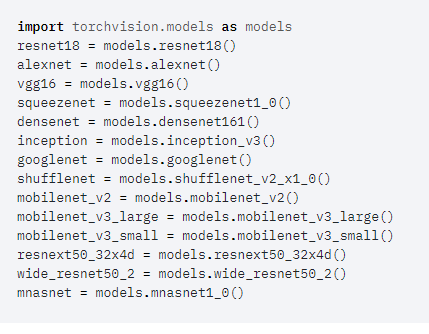


In [ ]:
# Import torchvision models
import torchvision.models as models

In [ ]:
# Create an object of the model
model_pretrained  = models.resnet18(pretrained=True).to(DEVICE)


In [ ]:
# ToDo
# Check the params and size. Compare with the other models.
summary(model_pretrained, input_size=(3,224,224))

In [ ]:
# Lets Look the configuration of the network.
# check the kernel size of the first layer, 
# check the output shape of last layer.
print(model_pretrained.parameters)

In [ ]:
# Looking the printed values, we can look deeeper about some layers configuration
print(model_pretrained.layer4)
print(model_pretrained.fc)

In [ ]:
# We can also import the network without the pretrained weights, and define some configuration in it.
model_NOT_pretrained2 = nn.Sequential(
    models.resnet18(pretrained=False, num_classes=2),
    nn.LogSoftmax(dim=1)
    )

model_NOT_pretrained2.to(DEVICE)
# print(model_pretrained2.fc)

In [ ]:
DEVICE= 'cuda' if torch.cuda.is_available() else 'cpu'
num_epochs=10
learning_rate = 0.01
criterion = nn.NLLLoss() 

# ToDo
#  complete the proper inputs in the optimizer
optimizer = torch.optim.Adam(...)
#  Complete the inputs to the trainer
model_cnn=trainer_CNN(...)


In [ ]:
test_loader2 = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=len(df_files_test), shuffle=False, num_workers=0,drop_last=True)

for test_data in test_loader2:
  with torch.no_grad():
    y_pred = model_NOT_pretrained2( test_data['image'].to(DEVICE) )
  _, predicted = torch.max(y_pred.data, 1)
  print(classification_report( test_data['target'].cpu(), predicted.cpu() ))
  acc = predicted.eq(test_data['target'].to(DEVICE)).sum()
  print(f'Batch Accuracy: {acc.item()/predicted.shape[0]*100}%' )
  # from https://juansensio.com/blog/065_transformer_decoder
  r, c = 8,5
  fig = plt.figure(figsize=(c*2,r*2) )
  for r_ in range(r):
    for c_ in range(c):
      ix = r_*c + c_ 
      ax = plt.subplot(r,c, ix+1)
      img = test_data['image'][ix].cpu().numpy().transpose()
      img = (img-img.min())/(img.max()-img.min())
      label = test_data['target'][ix].cpu().numpy()
      pred = predicted[ix].cpu().numpy().item()
      ax.imshow(img)
      ax.set_title( str(pred)+'/'+str(label), color='green' if label==pred else 'red'  )
  plt.tight_layout()
  plt.show()
  break

# Pretrained_True but Fine-tunning

In this part of the notebook, we will freeze some layers and unfreeze it to re-train the entire netwoork again

![link text](https://pyimagesearch.com/wp-content/uploads/2019/06/fine_tuning_keras_freeze_unfreeze.png)

In [ ]:
model_pretrained3 = nn.Sequential(model_pretrained,
                                  nn.Linear(1000,2),
                                  nn.LogSoftmax(dim=1)
                                  )
model_pretrained3.to(DEVICE)
print(model_pretrained3[-2].weight.shape)

In [ ]:
## Freezing some layers

for param in model_pretrained3[0].parameters():
  # print(param.shape)
  # Todo 
  # Freeze the layers properly
  param. ... = False

In [ ]:
for param in model_pretrained3[0].parameters():
  # print(param.shape)
  # print(param.requires_grad)
  pass 
for param in model_pretrained3[1].parameters():
  print(param.requires_grad)

In [ ]:
# ToDo:  
# Check the num of parameters, as trainable and non-trainable
summary(model_pretrained3, input_size=(3,224,224))

In [ ]:
DEVICE= 'cuda' if torch.cuda.is_available() else 'cpu'
num_epochs=10
learning_rate = 0.01
criterion = nn.NLLLoss() #nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_pretrained3.parameters(), lr=learning_rate,weight_decay=0.001)
model_cnn=trainer_CNN(train_loader, test_loader, model_pretrained3, optimizer, num_epochs, criterion,DEVICE  )


In [ ]:
# Lets check again if the gradients are calculated
print(model_pretrained3[0].conv1.weight.requires_grad)


In [ ]:
test_loader2 = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=len(df_files_test), shuffle=False, num_workers=0,drop_last=True)

for test_data in test_loader2:
  with torch.no_grad():
    y_pred = model_pretrained3( test_data['image'].to(DEVICE) )
  _, predicted = torch.max(y_pred.data, 1)
  print(classification_report( test_data['target'].cpu(), predicted.cpu() ))
  acc = predicted.eq(test_data['target'].to(DEVICE)).sum()
  print(f'Batch Accuracy: {acc.item()/predicted.shape[0]*100}%' )
  # from https://juansensio.com/blog/065_transformer_decoder
  r, c = 8,5
  fig = plt.figure(figsize=(c*2,r*2) )
  for r_ in range(r):
    for c_ in range(c):
      ix = r_*c + c_ 
      ax = plt.subplot(r,c, ix+1)
      img = test_data['image'][ix].cpu().numpy().transpose()
      img = (img-img.min())/(img.max()-img.min())
      label = test_data['target'][ix].cpu().numpy()
      pred = predicted[ix].cpu().numpy().item()
      ax.imshow(img)
      ax.set_title( str(pred)+'/'+str(label), color='green' if label==pred else 'red'  )
  plt.tight_layout()
  plt.show()
  break

# Fine-Tunning entire model

We will now gonna train several variations... 


1.   Entire model with pretrained weights and Standardization as we have used
2.   Entire model with pretrained weights, using the standardization of ImageNet
3.   Entire model from the Fine-tuned





In [ ]:
# Create Dataset
# ToDO: Complete to make it work
class Dataset(torch.utils.data.Dataset):
  def __init__(self, img_path, desc_path, df_files, transforms):
    self.transforms  = transforms
    self.img_path  = img_path
    self.desc_path = desc_path 
    self.df_files = df_files
  def __len__(self,):
    return len(self.df_files)
  
  def __getitem__(self, idx):
    image  = Image.open(os.path.join(self.img_path, self.df_files['Name'][idx]+'.jpeg' ))
    image_name = self.df_files['Name'][idx]
    target = np.array(self.df_files['label_value'][idx])
    if self.transforms:
      image = self.transforms(image)
    return {
        'image_name':image_name,
        'image': image,
        'target': torch.from_numpy( target ).long()
    }

# ToDO.. uncomment the proper normalization for the task
train_composed = transforms.Compose([transforms.ToTensor(),
                               transforms.Resize(256),
                               transforms.RandomCrop(224),
                               transforms.RandomVerticalFlip(),
                               transforms.RandomHorizontalFlip(),
                               transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])
                               #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # normalize
            ])

val_composed = transforms.Compose([transforms.ToTensor(),
                               transforms.Resize(256),
                               transforms.RandomCrop(224),
                               #transforms.RandomVerticalFlip(),
                               #transforms.RandomHorizontalFlip(),
                               
                                transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])
            #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # normalize
            ])


## Create the object
dataset_train= Dataset(img_path=images_path,
                       desc_path=desc_path,
                       df_files=df_files_train,
                       transforms=train_composed )

## Create the object
dataset_test = Dataset(img_path=images_path,
                       desc_path=desc_path,
                       df_files=df_files_test,
                       transforms=val_composed )  

train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=64, shuffle=True, num_workers=0,drop_last=True)

test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=4, shuffle=False, num_workers=0,drop_last=True)


# Task 1:   Pretrained and tunne the entire network with standardization

In [ ]:
model_pretrained4 = nn.Sequential(model_pretrained,
                                  nn.Linear(1000,2),
                                  nn.LogSoftmax(dim=1)
                                  )
model_pretrained4.to(DEVICE)
model_pretrained4.train()
print(model_pretrained4[-2].weight.shape)

In [ ]:
for param in model_pretrained4[0].parameters():
  # ToDo UnFreeze the layer weights
  param. ... = True

In [ ]:
model_pretrained4[0].conv1.weight.requires_grad

In [ ]:
DEVICE= 'cuda' if torch.cuda.is_available() else 'cpu'
num_epochs=10
learning_rate = 0.01
criterion = nn.NLLLoss() #nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_pretrained4.parameters(), lr=learning_rate,weight_decay=0.01)
model_cnn=trainer_CNN(train_loader, test_loader, model_pretrained4, optimizer, num_epochs, criterion,DEVICE  )


In [ ]:
test_loader2 = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=len(df_files_test), shuffle=False, num_workers=0,drop_last=True)

for test_data in test_loader2:
  with torch.no_grad():
    y_pred = model_pretrained4( test_data['image'].to(DEVICE) )
  _, predicted = torch.max(y_pred.data, 1)
  print(classification_report( test_data['target'].cpu(), predicted.cpu() ))
  acc = predicted.eq(test_data['target'].to(DEVICE)).sum()
  print(f'Batch Accuracy: {acc.item()/predicted.shape[0]*100}%' )
  r, c = 8,5
  fig = plt.figure(figsize=(c*2,r*2) )
  for r_ in range(r):
    for c_ in range(c):
      ix = r_*c + c_ 
      ax = plt.subplot(r,c, ix+1)

      img = test_data['image'][ix].cpu().numpy().transpose()
      img = (img-img.min())/(img.max()-img.min())

      
      label = test_data['target'][ix].cpu().numpy()

      
      pred = predicted[ix].cpu().numpy().item()
      ax.imshow(img)
      ax.set_title( str(pred)+'/'+str(label), color='green' if label==pred else 'red'  )
  plt.tight_layout()
  plt.show()
  break

# Task2 : Pretrained with tunning entire network and normalization of Imagenet

In [ ]:
 # ToDO 
 #  1. Change Dataset to use   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # normalization ImageNet
 #  2. Define the pretrained network as a Sequential 
 


In [ ]:
DEVICE= 'cuda' if torch.cuda.is_available() else 'cpu'
num_epochs=10
learning_rate = 0.01
criterion = nn.NLLLoss() #nn.CrossEntropyLoss()

### Change the name of the model
optimizer = torch.optim.Adam(model_pretrained5.parameters(), lr=learning_rate,weight_decay=0.01)
model_cnn=trainer_CNN(train_loader, test_loader, model_pretrained4, optimizer, num_epochs, criterion,DEVICE  )


In [ ]:
# ToDo:
#  Perform the Test

# Task3: Entire model from the Fine-tuned

In [ ]:
model_pretrained6 = copy.deepcopy(model_pretrained3)
model_pretrained6.to(DEVICE)
# print(model_pretrained3[-2].weight.shape)

In [ ]:
for param in model_pretrained6[0].parameters():
  # print(param.shape)
  param.requires_grad = True

In [ ]:
# ToDo
# Set the training parameters 
# Train for 10 epochs
# Test the results with best model